In [55]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from image import *
import csv  
from io import BytesIO
from IPython import display

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

import torch
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
import h5py

from tensorflow.keras.layers import StringLookup

from ML_helper import *

from corrections import *
from image import * 
from handling import *

In [56]:
def extract_vertices(bounding_box):
    vertices = []
    for vertex in bounding_box.vertices:
        vertices.append((vertex.x, vertex.y))
    return vertices

def combine_paraboxes(para_boxes):
    X_points = []
    Y_points = []
    for box in para_boxes:
        for vertex in box:
            X_points.append(vertex[0])
            Y_points.append(vertex[1])

    X_points = np.array(X_points)
    Y_points = np.array(Y_points)

    para_box = np.zeros((4,2), dtype=np.int32)

    para_box[0] = [X_points.min(), Y_points.min()]
    para_box[1] = [X_points.max(), Y_points.min()]
    para_box[2] = [X_points.max(), Y_points.max()]
    para_box[3] = [X_points.min(), Y_points.max()]

    return para_box

def rotate_image_and_transform_coordinates(image, coordinates, angle):

    angle = np.rad2deg(angle)

    # Calculate the transformation matrix.
    transform_matrix = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)

    # Apply the transformation matrix to the coordinates.
    image = cv2.warpAffine(image, transform_matrix, (image.shape[1], image.shape[0]))

    transformed_coordinates = [(transform_matrix[:,:2] @ coordinates[i].T).T + transform_matrix[:,2] for i in range(len(coordinates))]

    return image, transformed_coordinates

def zero_printed_text(image, threshold=40, verbose=False):

    mask = np.zeros(image.shape, dtype=np.uint8)

    mask[(image>0) & (image<threshold)] = 1

    nx, ny = image.shape

    # mask[nx//6:4*nx//6, ny//6:5*ny//6] = 0 #havent worked this bit out yet

    dilated = cv2.dilate(mask, np.ones((9,9), np.uint8), iterations=1)

    return image * (1-dilated)


In [159]:
def extract_ID_handwriting(frame, paragraph_vertices, verbose=False):
        
    padx = 60
    pady = 30

    #firstly find the box around the identity, and also calculate the approx angle of rotation of that box. 
    adapted_para_box = paragraph_vertices.copy()

    x = np.argsort(paragraph_vertices[:,0])
    y = np.argsort(paragraph_vertices[:,1])


    adapted_para_box[x[:2],0] = np.max( np.stack(( paragraph_vertices[x[:2],0] - padx , [0,0] )), axis=0)

    adapted_para_box[x[2:],0] = np.min( np.stack(( paragraph_vertices[x[2:],0] + 1.2*padx , [frame.shape[1] - 1,frame.shape[1] - 1] )), axis=0)

    adapted_para_box[y[:2],1] = np.max( np.stack(( paragraph_vertices[y[:2],1] - pady, [0,0] )), axis=0) 
    adapted_para_box[y[2:],1] = np.min( np.stack(( paragraph_vertices[y[2:],1] + pady , [frame.shape[0] - 1,frame.shape[0] - 1])), axis=0)


    rel_area = polygon(adapted_para_box[:,1], adapted_para_box[:,0]) 
    mask1 = np.zeros(frame.shape[:2], dtype=np.uint8)
    mask1[rel_area] = 1

    miny, maxy, minx, maxx = np.min(adapted_para_box[:,0]), np.max(adapted_para_box[:,0]), np.min(adapted_para_box[:,1]), np.max(adapted_para_box[:,1])


    idx = paragraph_vertices[:,1].argsort()[:2]
    dx = paragraph_vertices[idx[1],0] - paragraph_vertices[idx[0],0]
    dy = paragraph_vertices[idx[1],1] - paragraph_vertices[idx[0],1]

    angle = np.arctan2(dy,dx)


    if verbose:
        fig,ax = plt.subplots(1,6,dpi=250)
        ax[0].imshow(frame)
    frame = frame*mask1[...,None] #mask the image

    if verbose: ax[1].imshow(frame)

    frame = np.mean(frame, axis=2)
    frame = frame[minx:maxx, miny:maxy]

    if verbose: ax[2].imshow(frame)

    frame = rotate(frame, -angle, resize=False, ) #rotate the image
    # frame = (1-frame) #invert and threshold.
    # frame[frame < 0.5] = 0
    # frame[frame !=0] = 1

    if verbose: ax[3].imshow(frame)


    frame = zero_printed_text(frame, threshold = 30) #threshold needs to be found algorithmically.


    hist = np.histogram(frame, bins=100)
    peaks,_ = scipy.signal.find_peaks(hist[0], height=1000, distance=7)

    if len(peaks) == 2:
        peak_handwriting = peaks[0]
        peak_background = peaks[1]

        thresh = 1*hist[1][peak_background]/4  + 3*hist[1][peak_handwriting]/4
    else:
        thresh = frame.max()*0.85
        


    frame[frame>thresh] = 0 
    frame[frame!=0] = 1

    if verbose: ax[4].imshow(frame)


    from skimage.segmentation import clear_border
    # kernel = np.ones((5, 5), np.uint8)
    # frame = cv2.erode(frame, kernel, iterations=1)
    
    # frame = clear_border(frame)

    if verbose: ax[5].imshow(frame)

    return frame

In [203]:
def GetImageAndParaBox(file, client, verbose=False):
    client = vision.ImageAnnotatorClient()
    whole_image = RetreiveImage(file, verbose=False)

    img_byte_array = CroppedImage(whole_image, verbose=False)

    decoded = np.frombuffer(img_byte_array.getvalue(), dtype=np.uint8)
    frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 

    content = img_byte_array.getvalue()
    image = vision.Image(content=content)

    response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

    characters = []
    character_params = []
    character_heights = [] 

    for a, page in enumerate(response.full_text_annotation.pages):
        for b, block in enumerate(page.blocks):
            for c, paragraph in enumerate(block.paragraphs):
                for d, word in enumerate(paragraph.words):
                    for e, symbol in enumerate(word.symbols):

                        # Save character details
                        characters.append(symbol.text)
                        character_params.append([a, b, c, d, e])
                        if verbose: print(characters[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))

                        # Save the height of each character.
                        vertices = extract_vertices(symbol.bounding_box)
                        character_heights.append(np.sort(vertices[0])[0])
                        if verbose: print('character:', symbol.text, 'upper height:', np.sort(vertices[0])[0], 'lower height:', np.sort(vertices[0])[1])

                        # if (character_height - ( (character_height - first_height) * 0.2)) <= np.sort(vertices[0])[0] <= (character_height + ( (character_height - first_height) * 0.2)):
                        #     ID_vertices.append(np.array(vertices))

                        #     if verbose: print('character:', symbol.text, 'is within bounds')
                        #     include_indices.append(i)
                        
                        # i += 1

    character_params = np.array(character_params)

    # If we have not read enough characters, the label may be moved outside the cropping box. Resort to reading the whole image and repeat above.
    if len(characters) < 7:
        if verbose: print('\nNot enough characters in ID, running with the whole image.')

        client = vision.ImageAnnotatorClient()
        content = whole_image.getvalue()
        image = vision.Image(content=content)
        response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

        decoded = np.frombuffer(whole_image.getvalue(), dtype=np.uint8)
        frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 

        characters = []
        character_params = []
        character_heights = [] 

        for a, page in enumerate(response.full_text_annotation.pages):
            for b, block in enumerate(page.blocks):
                for c, paragraph in enumerate(block.paragraphs):
                    for d, word in enumerate(paragraph.words):
                        for e, symbol in enumerate(word.symbols):

                            # Save character details
                            characters.append(symbol.text)
                            character_params.append([a, b, c, d, e])
                            if verbose: print(characters[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))

                            # Save the height of each character.
                            vertices = extract_vertices(symbol.bounding_box)
                            character_heights.append(np.sort(vertices[0])[0])
                            if verbose: print('character:', symbol.text, 'upper height:', np.sort(vertices[0])[0], 'lower height:', np.sort(vertices[0])[1])

        character_params = np.array(character_params)

    # Remove everything before M or F.
    if 'M' in characters or 'F' in characters:
        lead_character = characters[0]
        while lead_character != 'F' and lead_character != 'M':

            if verbose: print('\nRemoving everything before F and M')
            if verbose: print('removing character', characters[0])

            characters = characters[1:]
            character_params = character_params[1:]
            character_heights = character_heights[1:]
            lead_character = characters[0]

            if verbose: print('Reduced characters are now:', characters)
            if verbose: print('Lead character is now:', lead_character)

            # If we drop below 7 characters then end then break
            if len(characters) < 7:
                if verbose: print("Not enough characters to continue. Breaking the cycle.")
                break

    # Removing the three title characters:
    if verbose: print('Removing the title characters')
    characters = characters[3:]
    character_params = character_params[3:]
    character_heights = character_heights[3:]
    if verbose: print('Remaining characters are:', characters)

    # Remove the date and everything after
    if verbose: print('Removing date and characters after date')
    date_index = 3 + np.argmin(['/' in i for i in characters[5:]])
    print('date index is', date_index)
    if date_index == 4:
        pass
    else:
        characters = characters[:date_index]
        character_params = character_params[:date_index]
        character_heights = character_heights[:date_index]
        if verbose: 
            print('Remaining characters are:', characters)
            print('Ramaining character heights:', character_heights)

    # Character in the 3rd position of height.
    ordered_height = np.argsort(character_heights)
    if verbose: print('Character heights are:', character_heights)
    if verbose: print('Character height order is:', ordered_height)
    # focused_index = ordered_height[5]
    focused_index = 2
    if verbose: print('Character and height in position 3 is:', characters[focused_index], character_heights[focused_index])

    # 3rd character bounding box is:
    page_no, block_no, paragraph_no, word_no, symbol_no = character_params[focused_index] #take the 3rd character and use the words boudning box.
    character_bounds = extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].symbols[symbol_no].bounding_box)
    focused_height = np.sort(character_bounds[0])[0]
    if verbose: print('character height is:', focused_height)

    # Cycle through and find include all characters with similar height
    ID_indices = []
    for i, character_height in enumerate(character_heights):
        if (focused_height - (focused_height * 0.09) ) <= character_height <= (focused_height + (focused_height * 0.09) ):
            ID_indices.append(i)
            if verbose: print('Character', characters[i], 'falls within height bounds')

    # Remove any that are too far away from the central indicies (removes and stray date characters included)
    indices_diff = np.diff(ID_indices)
    for i, diff in enumerate(indices_diff):
        if diff > 3:
            if verbose: print('Removed %s as too far away from central indices' %characters[include_indices[i+1]])
            ID_indices = ID_indices[:i + 1]

    # If less than 4 characters in the ID, then manually add more.
    while len(ID_indices) < 4:
        if np.min(np.array(ID_indices)) == 0:
            also_include_index = np.max(np.array(ID_indices)) + 1
        else:
            also_include_index = np.min(np.array(ID_indices)) - 1
        ID_indices.insert(0, np.array(also_include_index))
        if verbose: print('Less than 4 chracters in ID. Adding', characters[also_include_index])

    ID_characters = []
    ID_character_params = []
    ID_vertices = []
    
    for index in ID_indices:

        character = characters[index]
        character_param = character_params[index]
        page_no, block_no, paragraph_no, word_no, symbol_no = character_param
        character_bounds = extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].symbols[symbol_no].bounding_box)

        ID_characters.append(character)
        ID_character_params.append(character_param)
        ID_vertices.append(extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].symbols[symbol_no].bounding_box))


    if verbose: print('Included characters and their indicies are:', ID_characters, ID_indices)

    # Sort the values of each bounding box to ensure the correct format for combine para_boxes
    # for i, vertex in enumerate(ID_vertices):
    #     for j, coord in enumerate(vertex):
    #         ID_vertices[i][j] = np.sort(coord)[::-1]

    if verbose: print('Number of bounding boxes', len(ID_vertices))

    para_boxes = np.array(ID_vertices)
    para_box = combine_paraboxes(para_boxes)

    if verbose: plt.imshow(frame)

    return frame, para_boxes

In [104]:
new_files = ListAvaliableFiles("guppy_images", "Manually_Labelled/New")
new_jpg_files = [ x for x in new_files if "JPG" in x ]

np.random.shuffle(new_jpg_files)

F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: F upper height: 148 lower height: 252
L pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
character: L upper height: 238 lower height: 239
L pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
character: L upper height: 227 lower height: 320
6 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:0
character: 6 upper height: 26 lower height: 416
F pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:1
character: F upper height: 141 lower height: 395
8 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:2
character: 8 upper height: 244 lower height: 377
N pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:3
character: N upper height: 353 lower height: 380
1 pageno:0 blockno:0 paragraphno:1 wordno:1 symbolno:0
character: 1 upper height: 72 lower height: 627
/ pageno:0 blockno:0 paragraphno:1 wordno:1 symbolno:1
character: / upper height: 138 lower height: 619
2 pageno:0 blockno:0 paragraphno:1 wordno:1 symbolno:2
character: 

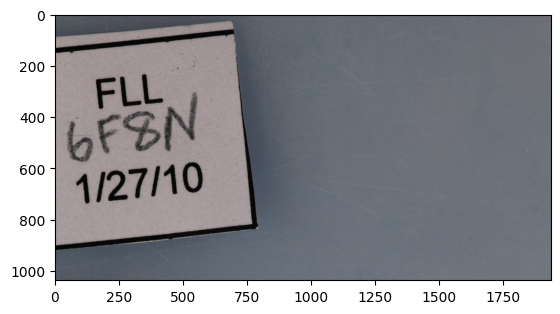

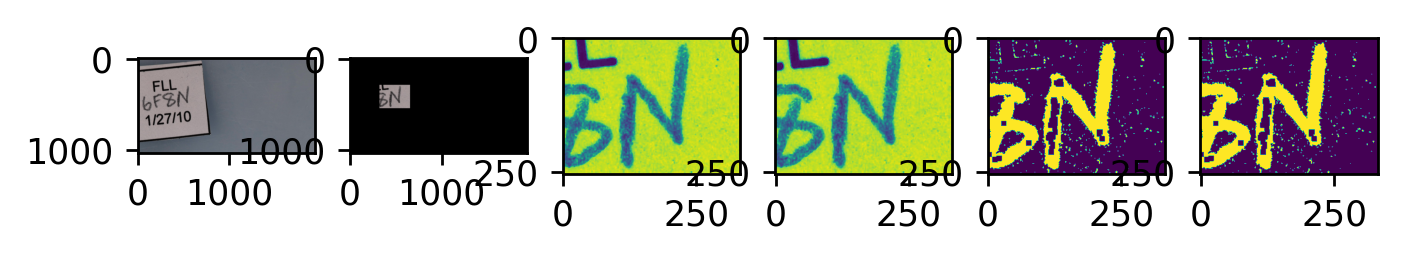

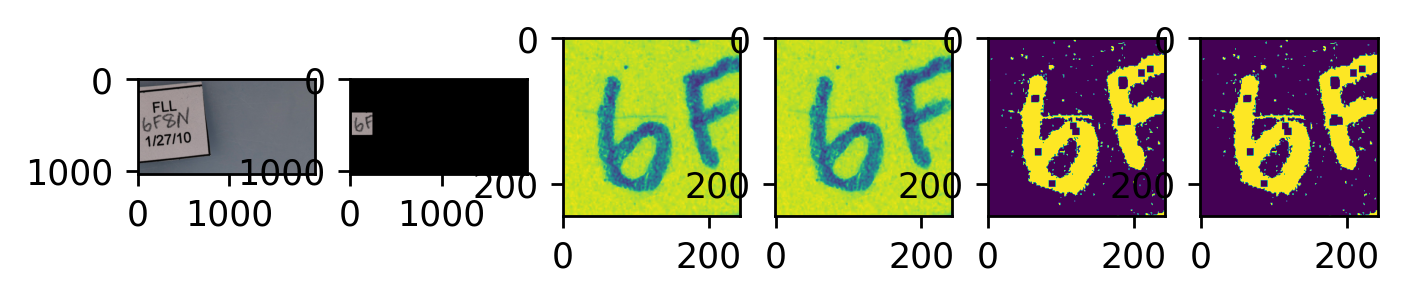

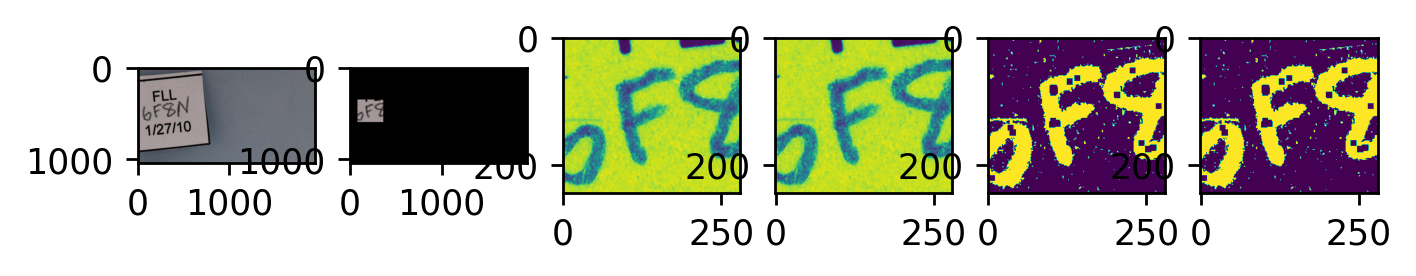

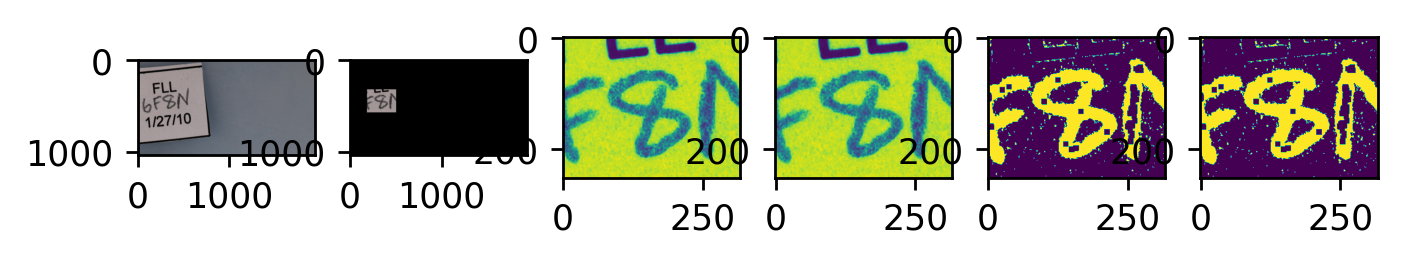

In [204]:
client = vision.ImageAnnotatorClient()
file = new_jpg_files[2]
frame, para_boxes = GetImageAndParaBox(file, client, verbose=True)

for i, box in enumerate(para_boxes):
    boxes = combine_paraboxes([box])
    ID = extract_ID_handwriting(frame, boxes, verbose=True)

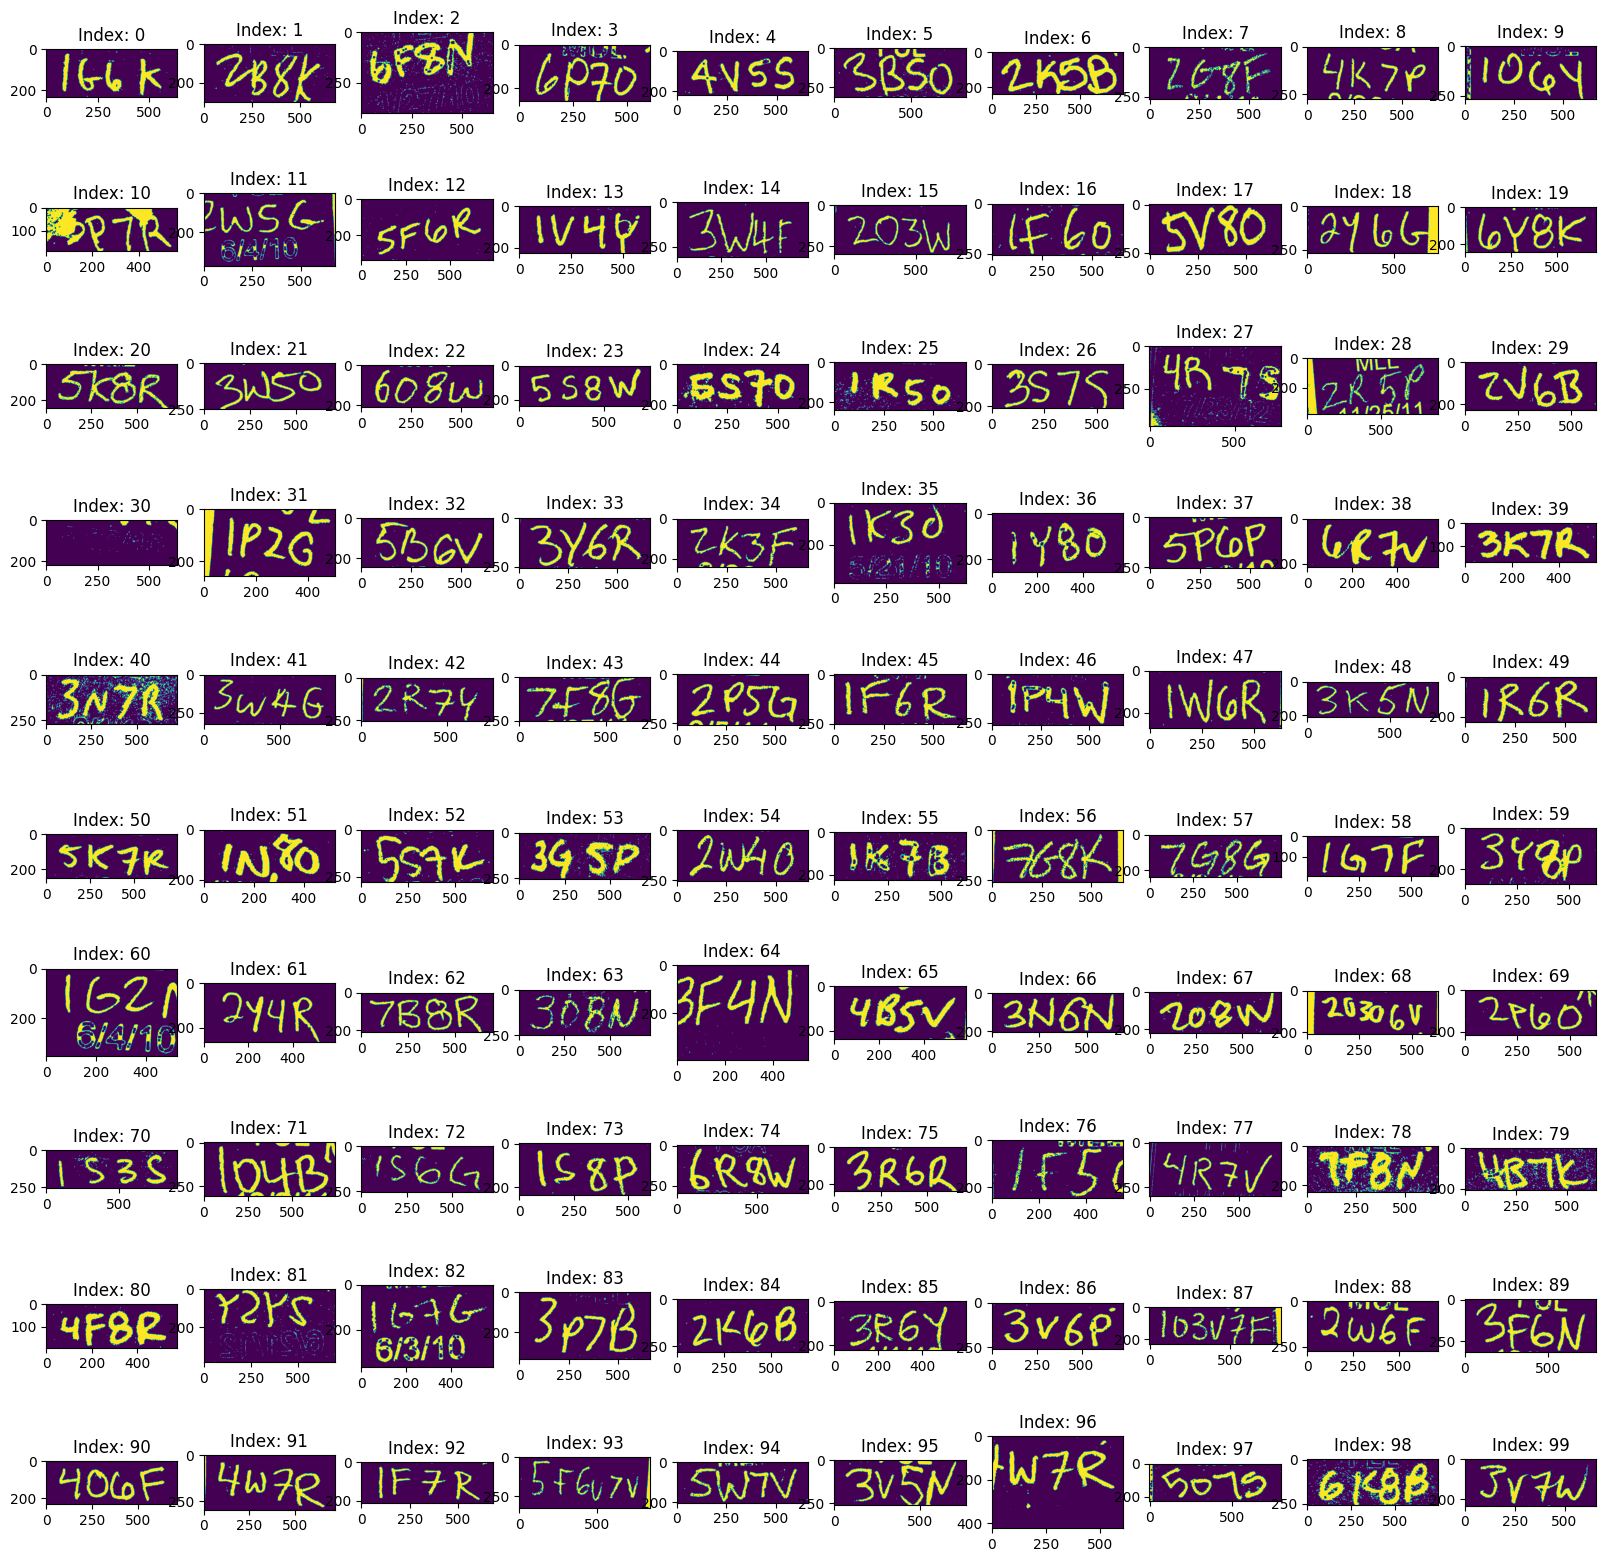

In [184]:
client = vision.ImageAnnotatorClient()

fig,ax = plt.subplots(10,10, figsize=(20,20))
for i in range(100):
    frame, para_boxes = GetImageAndParaBox(new_jpg_files[i], client, verbose=False)
    para_box = combine_paraboxes(para_boxes)
    try:
        ID = extract_ID_handwriting(frame, para_box, verbose=False)
        # ax[i].imshow(ID)
        ax[i//10, i%10].imshow(ID)
        ax[i//10, i%10].set_title('Index: %i' %i)
    except:
        pass

# plt.tight_layout()

In [178]:
characters = ['*', '4', 'B', '5', 'V', '1', '-', '2', '4', '-', '1', '0']
date_index = np.argmax(['/' in i for i in characters[::-1]])
characters = characters[:(-1) * date_index]
characters

[]

In [176]:
characters[::-1]

['0', '1', '-', '4', '2', '-', '1', 'V', '5', 'B', '4', '*']

In [179]:
date_index

0

In [202]:
characters = ['6', 'F', '8', 'N', '1', '/', '2', '7', '/', '1', '0']
date_index = 4 + np.argmin(['/' in i for i in characters[5:]])

In [195]:
date_index

4

In [201]:
np.argmin(['/' in i for i in characters[5:]])

1

In [198]:
characters[5:]

['/', '2', '7', '/', '1', '0']